<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/fluidflow/twophasepipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculation of pressure drop in multi phase pipelines

This notebook is part of [introduction to natural gas processing using NeqSim](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb).

Litterature:
http://www.drbratland.com/

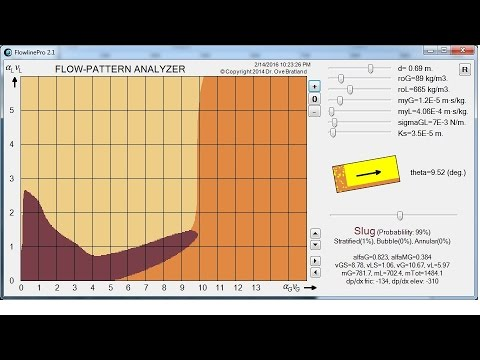

In [1]:
#@title Introduction to Calculation of pressure drop in multi phase pipelines
#@markdown Calculation of pressure drop in multi phase pipelines
from IPython.display import YouTubeVideo
YouTubeVideo('7Tsomarcq30', width=600, height=400)

In [2]:
%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('classic')
%matplotlib inline

# Demo of a simple NeqSim multi phase pipeline simulation

In [16]:
from neqsim import methods, jNeqSim
from neqsim.thermo import fluid, TPflash, createfluid2,printFrame
from neqsim.process import pipe, pipeline, clearProcess, stream, runProcess

#Creating inlet fluid using SRK-EoS
names = ['methane', 'n-heptane', 'water']
molefractions = [0.8, 0.1, 0.01]
fluid1 = createfluid2(names, molefractions)
fluid1.setMultiPhaseCheck(True)
fluid1.setMixingRule('classic')

#Creating stream and pipeline
clearProcess()
stream1 = stream(fluid1)
stream1.setFlowRate(20.0, "MSm3/day")
stream1.setTemperature(50.15, "C")
stream1.setPressure(100.0, "bara")

pipe = jNeqSim.processSimulation.processEquipment.pipeline.PipeBeggsAndBrills(stream1);
pipe.setDiameter(0.710);
pipe.setPipeWallRoughness(5e-6);
pipe.setLength(100000);
pipe.setElevation(0.0);
pipe.setAngle(0);
pipe.setNumberOfIncrements(5);

runProcess()
pipe.run()

print('flow regine ', pipe.getFlowRegime())
print('pressure drop ', pipe.getPressureDrop(), ' bara')
print('superficial velocity ' , pipe.getSuperficialVelocity(), ' m/sec')

flow regine  INTERMITTENT
pressure drop  40.41209715329897  bara
superficial velocity  5.1674180129306295  m/sec


In [17]:
printFrame(stream1.getFluid())
printFrame(pipe.getOutStream().getFluid())

| 0                  | 1          | 2                  | 3                  | 4                  | 5   | 6               |
|:-------------------|:-----------|:-------------------|:-------------------|:-------------------|:----|:----------------|
|                    | total      | GAS                | OIL                | AQUEOUS            |     |                 |
| methane            | 8.79121E-1 | 9.86375E-1         | 3.66368E-1         | 2.01975E-6         |     | [mole fraction] |
| n-heptane          | 1.0989E-1  | 1.21266E-2         | 6.32445E-1         | 8.74637E-23        |     | [mole fraction] |
| water              | 1.0989E-2  | 1.49851E-3         | 1.18645E-3         | 9.99998E-1         |     | [mole fraction] |
|                    |            |                    |                    |                    |     |                 |
| Density            |            | 7.12612E1          | 5.90128E2          | 9.79882E2          |     | [kg/m^3]        |
| PhaseFraction 

Text(0, 0.5, 'pressure [bara]')

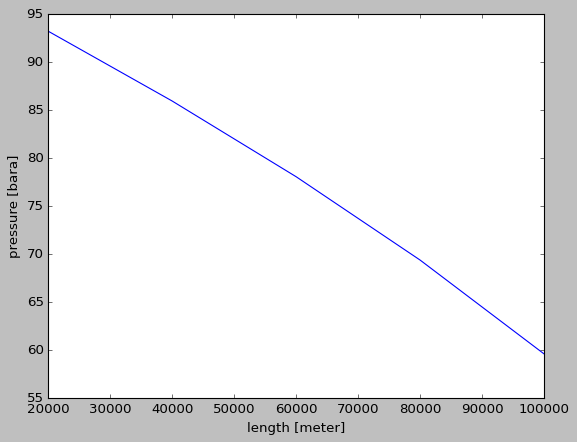

In [18]:
import matplotlib.pyplot as plt
plt.plot(pipe.getLengthProfile(), pipe.getPressureProfile())
plt.xlabel('length [meter]')
plt.ylabel('pressure [bara]')

Text(0, 0.5, 'velocity [m/sec]')

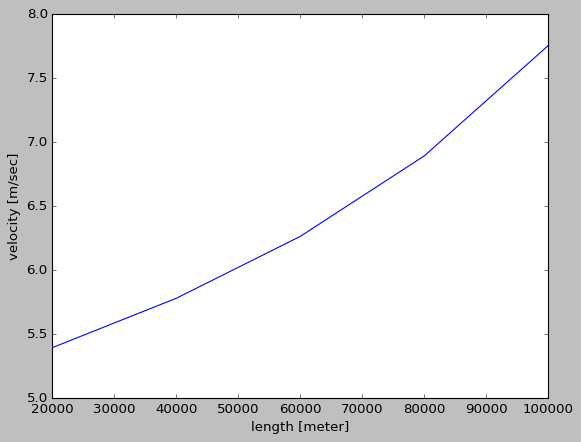

In [19]:
plt.plot(pipe.getLengthProfile(), pipe.getMixtureSuperficialVelocityProfile())
plt.xlabel('length [meter]')
plt.ylabel('velocity [m/sec]')

| 0                  | 1          | 2                  | 3                  | 4                  | 5   | 6               |
|:-------------------|:-----------|:-------------------|:-------------------|:-------------------|:----|:----------------|
|                    | total      | GAS                | OIL                | AQUEOUS            |     |                 |
| methane            | 8.79121E-1 | 9.86375E-1         | 3.66368E-1         | 2.01975E-6         |     | [mole fraction] |
| n-heptane          | 1.0989E-1  | 1.21266E-2         | 6.32445E-1         | 8.74637E-23        |     | [mole fraction] |
| water              | 1.0989E-2  | 1.49851E-3         | 1.18645E-3         | 9.99998E-1         |     | [mole fraction] |
|                    |            |                    |                    |                    |     |                 |
| Density            |            | 7.12612E1          | 5.90128E2          | 9.79882E2          |     | [kg/m^3]        |
| PhaseFraction 

#Calculation of inlet pressure based on outlet pressure and flow
In the following example fwe will use the Beggs and Brill method for a multi phase pipeline.

In [5]:
from neqsim import methods
from neqsim.thermo import fluid, TPflash, createfluid2
from neqsim.process import pipe, pipeline, clearProcess, stream, runProcess
from neqsim import jNeqSim
from scipy.optimize import least_squares

#Creating inlet fluid using SRK-EoS
names = ['water', 'CO2', 'nitrogen', 'methane', 'ethane', 'n-heptane']
molefractions = [0.1, 0.01, 0.01, 0.77, 0.01, 0.1]
fluid1 = createfluid2(names, molefractions)
fluid1.setMixingRule('classic')
fluid1.setMultiPhaseCheck(True)

##Defining the pipeline
diameter2 = 32*0.0254

#Establish the process
stream1 = jNeqSim.processSimulation.processEquipment.stream.Stream(fluid1)
stream1.setFlowRate(10.0, "MSm3/day")
stream1.setTemperature(5.0, "C")
stream1.setPressure(50.0, "bara")

pipe = jNeqSim.processSimulation.processEquipment.pipeline.PipeBeggsAndBrills(stream1);
pipe.setDiameter(diameter2);
pipe.setPipeWallRoughness(5e-6);
pipe.setLength(150000);
pipe.setElevation(300.0);
pipe.setNumberOfIncrements(10);

def calcinpres(inletpressure):
  stream1.setFlowRate(flow, "MSm3/day")
  stream1.setPressure(inletpressure, "bara")
  stream1.run()
  pipe.run()
  return pipe.getOutletPressure()-outletpressure


#set flow and outlet pressure to calculate inlet pressure
for flows in [0.5, 1, 2, 3, 4]:
  for outletpres in[5, 10,15]:
    outletpressure = outletpres
    flow = flows
    inletpres = least_squares(calcinpres, outletpressure+50.0, bounds = ((0.0,  np.inf)),verbose=0);
    print('inlet pressure ' ,inletpres.x, ' otlet pressure ', outletpres,  'flow ', flow, ' flow regime ', pipe.getFlowRegime())

inlet pressure  [7.32012621]  otlet pressure  5 flow  0.5  flow regime  SEGREGATED
inlet pressure  [13.35940861]  otlet pressure  10 flow  0.5  flow regime  SEGREGATED
inlet pressure  [19.3130554]  otlet pressure  15 flow  0.5  flow regime  SEGREGATED
inlet pressure  [7.7735356]  otlet pressure  5 flow  1  flow regime  SEGREGATED
inlet pressure  [13.37532272]  otlet pressure  10 flow  1  flow regime  SEGREGATED
inlet pressure  [19.10138525]  otlet pressure  15 flow  1  flow regime  SEGREGATED
inlet pressure  [9.40781551]  otlet pressure  5 flow  2  flow regime  SEGREGATED
inlet pressure  [14.35398889]  otlet pressure  10 flow  2  flow regime  SEGREGATED
inlet pressure  [19.62667766]  otlet pressure  15 flow  2  flow regime  SEGREGATED
inlet pressure  [12.09908531]  otlet pressure  5 flow  3  flow regime  SEGREGATED
inlet pressure  [15.60378509]  otlet pressure  10 flow  3  flow regime  SEGREGATED
inlet pressure  [20.75264843]  otlet pressure  15 flow  3  flow regime  SEGREGATED
inlet p

In [6]:
#Establish the process
fluid1.setMultiPhaseCheck(True)
stream1 = jNeqSim.processSimulation.processEquipment.stream.Stream(fluid1)
stream1.setFlowRate(4.0, "MSm3/day")
stream1.setTemperature(5.0, "C")
stream1.setPressure(22.24586, "bara")
stream1.run()

pipe = jNeqSim.processSimulation.processEquipment.pipeline.PipeBeggsAndBrills(stream1);
pipe.setDiameter(diameter2);
pipe.setPipeWallRoughness(5e-6);
pipe.setLength(150000);
pipe.setElevation(300.0);
pipe.setNumberOfIncrements(20);
stream1.run()
pipe.run()


print('outlet pressure ', pipe.getOutletPressure(), ' flow regime ', pipe.getFlowRegime())

outlet pressure  15.412126440849294  flow regime  SEGREGATED
